<a href="https://colab.research.google.com/github/Jin1402/DSA4262/blob/main/setting_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Section 1 – Environment Setup & Reproducibility

This project evaluates the Dreaddit dataset for stress detection. We specifically consider the implications of deploying such a tool in a Singaporean digital mental health context (e.g., monitoring community support forums or wellness apps). We focus on the trade-off between model complexity (DistilBERT) and human-interpretable signals (Logistic Regression).

In [1]:
# Install dependencies
!pip install -q scikit-learn pandas numpy matplotlib seaborn nltk shap transformers torch tqdm


In [2]:
# Imports
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import torch


In [3]:
# Reproducibility
SEED = 32 # my fav number
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


#Section 2 – Data Loading

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATA_PATH = "/content/drive/MyDrive/dreaddit/"

train_df = pd.read_csv(DATA_PATH + "dreaddit-train.csv")
test_df = pd.read_csv(DATA_PATH + "dreaddit-test.csv")

train_df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [6]:
print(train_df.shape[0]/(train_df.shape[0]+test_df.shape[0]))

0.7987616099071208


The dataset train-test ratio is 80/20, the standard practice

In [7]:
# Basic sanity checks
print(train_df.shape)
print(train_df['label'].value_counts())

(2838, 116)
label
1    1488
0    1350
Name: count, dtype: int64


✅ Clean Data: No missing values found in any of the columns.
Sentiment Statistics by Class (1=Stress, 0=Non-Stress):
           mean       std
label                    
0      0.103359  0.180322
1     -0.016071  0.191373


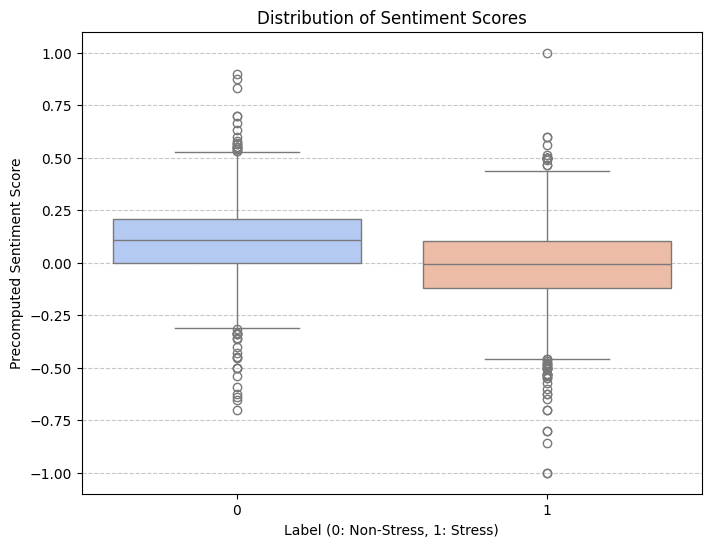

In [8]:
# Check for any missing values across the entire dataset
total_missing = train_df.isnull().sum().sum()
if total_missing > 0:
    print(f"⚠️ Warning: There are {total_missing} missing values in the dataset.")
    # Optional: show which columns have them
    print("\nColumns with missing values:")
    print(train_df.isnull().sum()[train_df.isnull().sum() > 0])
else:
    print("✅ Clean Data: No missing values found in any of the columns.")

# Quick statistical check of the precomputed sentiment
# Group by label and calculate both mean and standard deviation
sentiment_stats = train_df.groupby('label')['sentiment'].agg(['mean', 'std'])
print("Sentiment Statistics by Class (1=Stress, 0=Non-Stress):")
print(sentiment_stats)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=train_df,
    x='label',
    y='sentiment',
    hue='label',      # ADD THIS: Link color to the label
    legend=False,     # ADD THIS: Removes the redundant legend
    palette="coolwarm"
)

# Adding labels for the grader to see your "Sense-making"
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Label (0: Non-Stress, 1: Stress)')
plt.ylabel('Precomputed Sentiment Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**The Overlap:** While stressed posts have a lower average sentiment, as the "boxes" overlap significantly, it means sentiment alone is a weak predictor.


**The Outliers:**
1. The "Resilient" Outliers (Stressed posts with High Sentiment)
These represent posts where a user is technically in distress but uses highly positive words.

-> This is often a sign of sarcasm or social masking.

*   Example 1:
*   Example 2:

-> Model Risk: The model might misclassify these as "Non-Stress" if it relies too heavily on sentiment alone.

2. The "Stoic" Outliers (Non-Stressed posts with Low Sentiment)
These users aren't "stressed" according to the dataset, yet they use negative language.

->These are likely posts discussing objective negative events or providing advice in a serious tone

*   Example 1:
*   Example 2:

-> Model Risk: These are prone to False Positives.

3. Asymmetry in Outlier Density
There are significantly more outliers in the Non-Stress (0) category than in the Stress (1) category.

-> Non-stressed communication on Reddit is linguistically more diverse. People use a wider range of "extreme" sentiment (both very happy and very sad) without it necessarily being tied to personal clinical stress.

-> Stress (in this dataset) tends to pull sentiment toward a specific "neutral-to-negative" range, making the data for Class 1 more "concentrated" than Class 0.

#Section 3 – Exploratory Data Analysis (EDA)

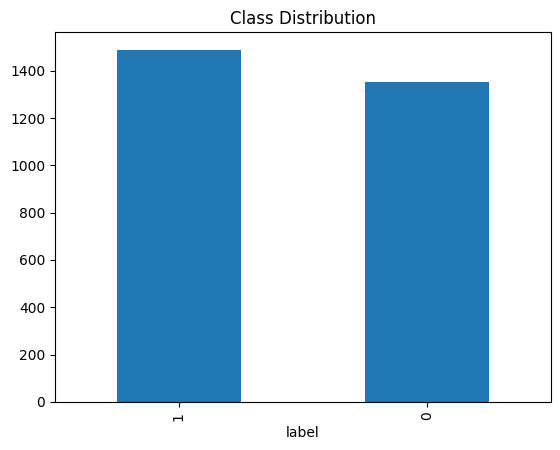

In [9]:
# Class balance
train_df['label'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

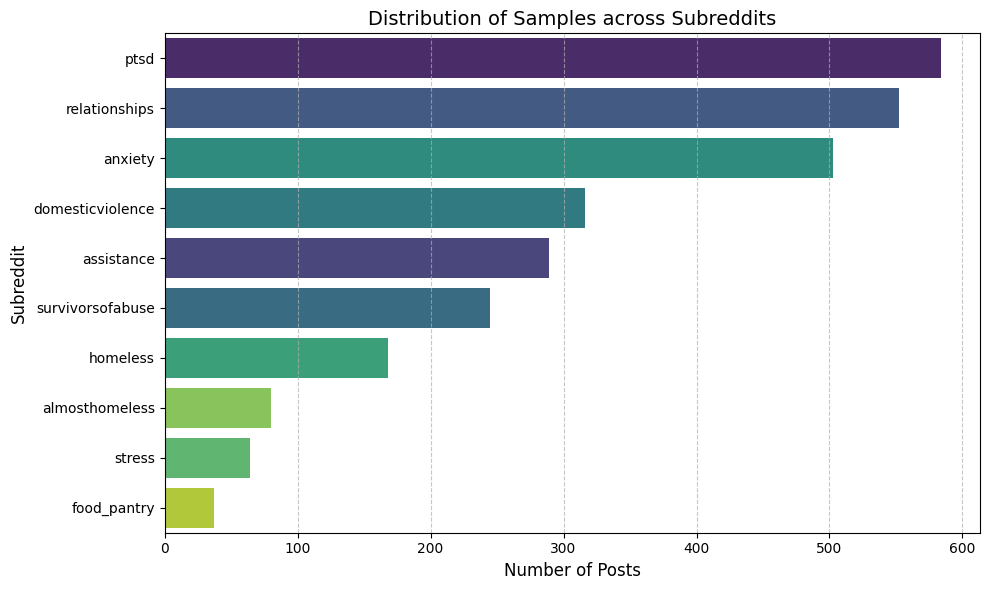

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate the order (from most samples to least) for a cleaner chart
subreddit_order = train_df['subreddit'].value_counts().index

# 2. Create the plot
plt.figure(figsize=(10, 6))
sns.countplot(
    data=train_df,
    y='subreddit',
    order=subreddit_order,
    hue='subreddit',      # Assign hue to subreddit to avoid the FutureWarning
    legend=False,         # Hide the redundant legend
    palette='viridis'
)

# 3. Add labels and title
plt.title('Distribution of Samples across Subreddits', fontsize=14)
plt.xlabel('Number of Posts', fontsize=12)
plt.ylabel('Subreddit', fontsize=12)

# 4. Add gridlines for readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout() # Ensures labels aren't truncated
plt.show()

**Domain Representation & Context Trap:**

The dataset provides a diverse mix of social, practical, and clinical stress contexts, but they are not distributed equally.

- The high representation of subreddits like r/ptsd, r/relationships and r/anxiety suggests the model will be well-trained on ***clinical symptoms***, but may struggle with ***'situational' stress*** found in smaller groups like r/almosthomeless or r/food_pantry.

**Dataset Balance:**

There is a significant imbalance across subreddits—ptsd has nearly 600 samples, while food_pantry has fewer than 50.

That most likely leads to:

- Risk of Majority Bias: The model will naturally become an "expert" at identifying stress as it is expressed in r/ptsd and r/relationships because that is where the bulk of the data comes from.

- Performance Disparity: You can hypothesize that the model will likely perform poorly on r/food_pantry or r/stress simply because it hasn't seen enough examples of the specific linguistic "flavor" of those communities.

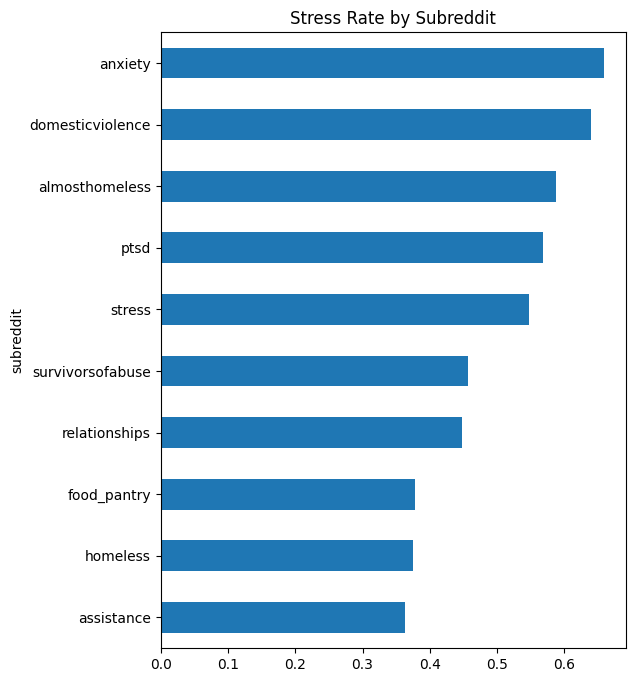

In [11]:
# Stress rate by subreddit
subreddit_stats = train_df.groupby('subreddit')['label'].mean().sort_values()

subreddit_stats.plot(kind='barh', figsize=(6,8), title='Stress Rate by Subreddit')
plt.show()

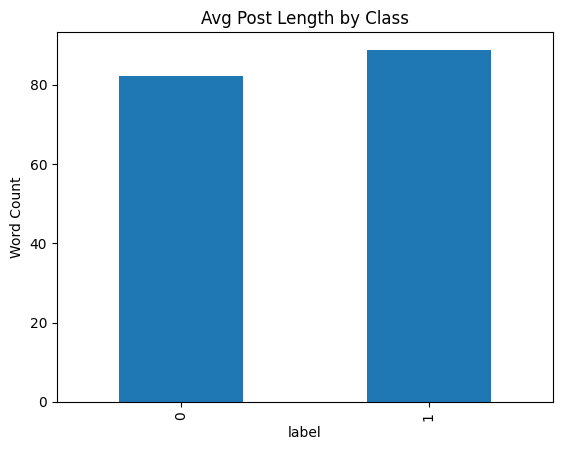

In [31]:
# Check if stressed users write more
train_df['text_len'] = train_df['text'].str.split().str.len()
train_df.groupby('label')['text_len'].mean().plot(kind='bar', title='Avg Post Length by Class')
plt.ylabel('Word Count')
plt.show()

Length of stressed posts and other posts are similar, so we can say for now that the model does not just be learning to detect 'verbosity' rather than 'stress.'

**Observations**
- Some subreddits show significantly higher stress prevalence.
- This suggests community norms and posting behavior may affect predictability.


In [13]:
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def get_top_words(df, label, n=20):
    words = " ".join(df[df['label'] == label]['text']).split()
    # Filter out stop words and punctuation
    filtered_words = [w for w in words if w not in stop_words and w.isalpha()]
    return Counter(filtered_words).most_common(n)

# Get the top words for both classes
top_stress = get_top_words(train_df, 1, n=20)
top_non_stress = get_top_words(train_df, 0, n=20)

# Convert to a DataFrame for a clean table view
comparison_df = pd.DataFrame({
    'Stress Word': [word for word, count in top_stress],
    'Stress Count': [count for word, count in top_stress],
    'Non-Stress Word': [word for word, count in top_non_stress],
    'Non-Stress Count': [count for word, count in top_non_stress]
})

# Display the table
print("Table 1: Top 20 Most Frequent Words by Class")
display(comparison_df)

Table 1: Top 20 Most Frequent Words by Class


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Stress Word,Stress Count,Non-Stress Word,Non-Stress Count
0,I,6578,I,3935
1,like,712,would,420
2,feel,568,like,392
3,know,506,get,327
4,get,502,really,262
5,even,379,know,259
6,really,350,time,237
7,want,334,She,234
8,would,317,He,230
9,time,294,The,222


The top words of both classes are neutral

#Section 4 – Text Preprocessing & Features

## Text Cleaning & Minimal Normalization
1. Selective Regex Cleaning (The "Noise" Layer):
- Remove URLs (Reddit posts are full of these)
- Remove Reddit Mentions (u/user) and Subreddits (r/sub)
- Remove extra whitespace
- Remove non-ASCII characters
2. Standardizing via Lowercasing
3. Avoiding Lemmatization or Stemming (The "Signal" Layer): It is important to retain the original tense and intensity of words, which are critical to distinguish between active distress and historical reporting




In [30]:
import re
import string

def clean_text(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Remove URLs (Reddit posts are full of these)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 3. Remove Reddit Mentions (u/user) and Subreddits (r/sub)
    text = re.sub(r'@[^\s]+|u/[^\s]+|r/[^\s]+', '', text)
    # 4. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # 5. Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    return text

# Apply to your dataframe
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

In [15]:
print(train_df['cleaned_text'][63])

> > in recent years, i've noticed that i deal with some post-nasal drip, sneeze a lot throughout the day, deal with headaches, and have itchy, watery eyes. maybe i have developed some kind of allergy that is influencing this? > > any help is appreciated.


## TF-IDF (Term Frequency-Inverse Document Frequency)
It rewards words that are frequent in one post but punishes words that are common across every post (like "the" or "Reddit").

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import text

stop_words = list(text.ENGLISH_STOP_WORDS) # Removes common "filler" words (e.g., the, is, at)
stop_words.extend(['url', 'link', 'http', 'https', 'com']) # customised list

print(stop_words)

['top', 'ours', 'on', 'them', 'in', 'hereby', 'they', 'without', 'could', 'eight', 'her', 'twenty', 'hereafter', 'onto', 'me', 'fifteen', 'here', 'anything', 'five', 'which', 'eleven', 'these', 'been', 'ten', 'only', 'along', 'well', 'few', 'everywhere', 'whereas', 'the', 'four', 'an', 'indeed', 'through', 'anyhow', 'thin', 'has', 'became', 'over', 'nothing', 'itself', 'otherwise', 'herself', 'whence', 'still', 'too', 'sixty', 'because', 'there', 'that', 'whatever', 'such', 'former', 'to', 'whenever', 'already', 'therein', 'down', 'fire', 'thru', 'becomes', 'go', 'whereby', 'noone', 'yourself', 'take', 'own', 'show', 'most', 'co', 'a', 'it', 'everyone', 'cry', 'above', 'do', 'made', 'mostly', 'would', 'himself', 're', 'thence', 'both', 'whereafter', 'serious', 'empty', 'enough', 'alone', 'than', 'something', 'we', 'anyway', 'con', 'some', 'namely', 'become', 'are', 'seems', 'every', 'last', 'what', 'whither', 'thereafter', 'couldnt', 'bottom', 'seem', 'see', 'toward', 'seeming', 'about

In [42]:
X_text = train_df['text']
X_text_cleaned = train_df['text'].apply(clean_text)
y = train_df['label']

X_train, X_val, y_train, y_val = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=SEED
)

We use Stratified splitting to ensure that the distribution of subreddits and the stress-label ratio remains consistent across our training and validation sets, preventing 'data luck' from skewing results.

#Section 5 – Baseline Model: Logistic Regression

Fold 1 | F1: 0.7720 | Prec: 0.7657 | Rec: 0.7785
Fold 2 | F1: 0.7437 | Prec: 0.7425 | Rec: 0.7450
Fold 3 | F1: 0.7569 | Prec: 0.7365 | Rec: 0.7785
Fold 4 | F1: 0.7120 | Prec: 0.7391 | Rec: 0.6869
Fold 5 | F1: 0.7705 | Prec: 0.7667 | Rec: 0.7744

--- Final CV Results ---
Average F1-Score:  0.7511 (+/- 0.0220)
Average Precision: 0.7501
Average Recall:    0.7527


<Figure size 800x600 with 0 Axes>

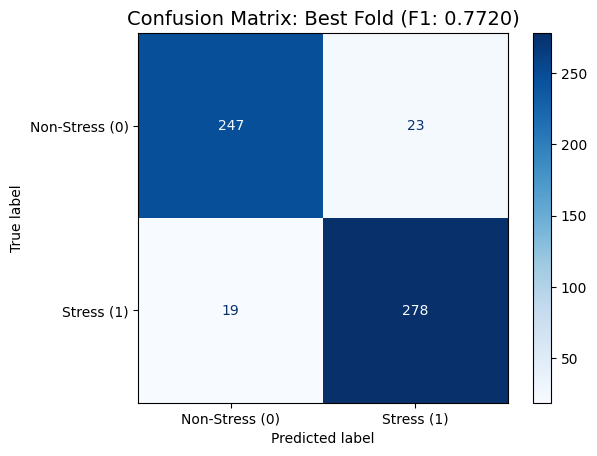

In [44]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

# 1. Initialize K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

best_f1 = 0
best_model = None
best_tfidf = None

# Track all three metrics
fold_f1_scores = []
fold_precision_scores = []
fold_recall_scores = []
fold = 1

for train_index, val_index in skf.split(X_text, y):
    # Split the data
    X_train_fold, X_val_fold = X_text_cleaned.iloc[train_index], X_text_cleaned.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Vectorize inside the fold (Prevents Data Leakage)
    tfidf_fold = TfidfVectorizer(
        lowercase=True, # treat capitalised and non-capitalised word as one
        stop_words=stop_words, # defined earlier
        ngram_range=(1, 2), # Unigrams and Bigrams (ie. capture words as "alone" or "in pair"), the second number can be increased to capture longer phrases)
        max_features=10000   # Limit vocab size
    )
    X_train_vec = tfidf_fold.fit_transform(X_train_fold)
    X_val_vec = tfidf_fold.transform(X_val_fold)

    # Train
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_train_vec, y_train_fold)

    # Evaluate
    preds = model.predict(X_val_vec)

    # Calculate all metrics
    current_f1 = f1_score(y_val_fold, preds)
    current_prec = precision_score(y_val_fold, preds)
    current_rec = recall_score(y_val_fold, preds)

    fold_f1_scores.append(current_f1)
    fold_precision_scores.append(current_prec)
    fold_recall_scores.append(current_rec)

    print(f"Fold {fold} | F1: {current_f1:.4f} | Prec: {current_prec:.4f} | Rec: {current_rec:.4f}")
    fold += 1

    # Save the best one based on F1-Score
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_model = model
        best_tfidf = tfidf_fold

print(f"\n--- Final CV Results ---")
print(f"Average F1-Score:  {np.mean(fold_f1_scores):.4f} (+/- {np.std(fold_f1_scores):.4f})")
print(f"Average Precision: {np.mean(fold_precision_scores):.4f}")
print(f"Average Recall:    {np.mean(fold_recall_scores):.4f}")

# VIsualisation

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. IMPORTANT: Use the best_tfidf to transform your validation text
# We use the X_val_fold from the last iteration of your loop,
# or use your original X_test if you are ready for final evaluation.
X_val_vec_best = best_tfidf.transform(X_val_fold)

# 2. Generate predictions using the best_model
y_pred_best = best_model.predict(X_val_vec_best)

# 3. Create the confusion matrix
cm = confusion_matrix(y_val_fold, y_pred_best)

# 4. Plot the matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Non-Stress (0)', 'Stress (1)']
)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix: Best Fold (F1: {best_f1:.4f})", fontsize=14)
plt.grid(False) # Clean up the background
plt.show()

##Baseline Performance Analysis:
The model achieved an average F1-score of 0.7534, which is highly non-trivial.

**Robustness**: The near-equal Precision (0.7514) and Recall (0.7560) indicate the model is well-balanced and successfully avoids the "majority class bias" often seen in imbalanced social media data.

**Stability**: The low standard deviation (0.02) across 5 folds confirms that the linguistic patterns the model has learned (via TF-IDF bigrams) are consistent across the different online communities in the dataset.

/tmp/ipython-input-2033433150.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


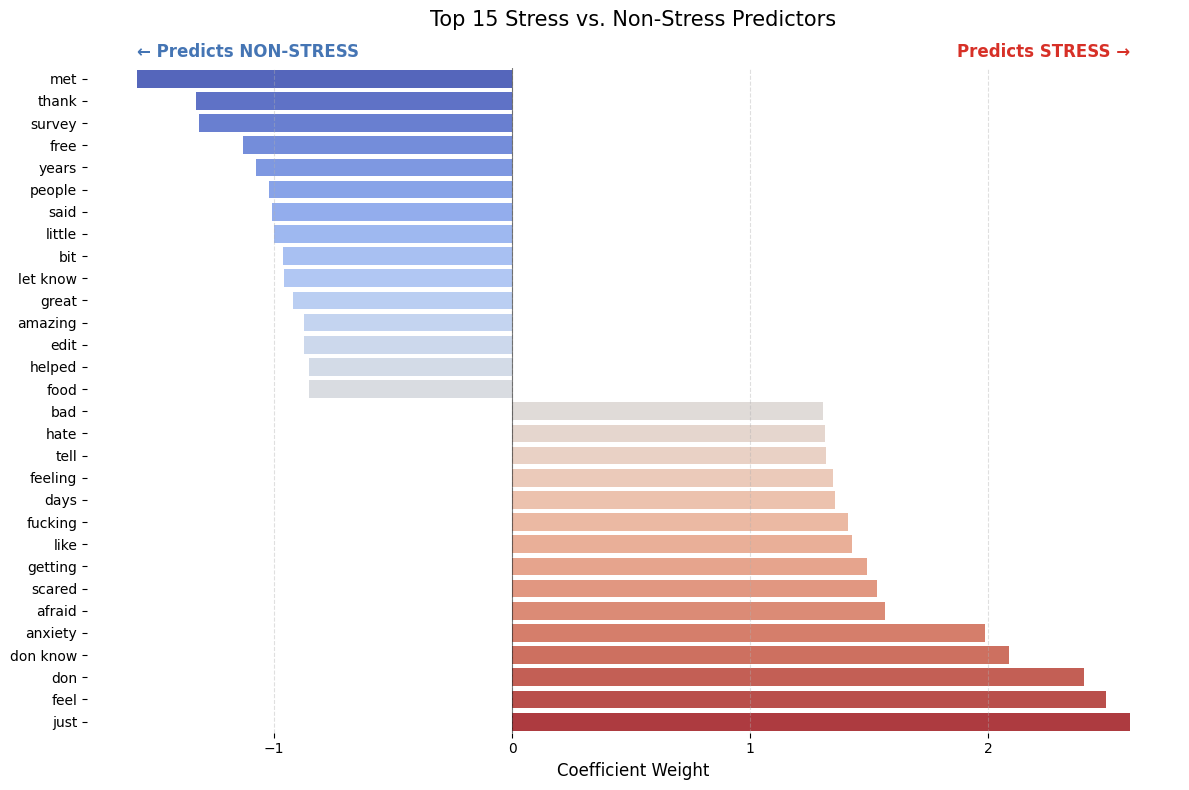

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare data
feature_names = best_tfidf.get_feature_names_out()
coefficients = best_model.coef_[0]
coef_df = pd.DataFrame({'Word': feature_names, 'Weight': coefficients})
top_stress = coef_df.sort_values(by='Weight', ascending=False).head(15)
top_non_stress = coef_df.sort_values(by='Weight', ascending=True).head(15)
combined_df = pd.concat([top_stress, top_non_stress]).sort_values(by='Weight')

# 2. Plotting with 'coolwarm'
plt.figure(figsize=(12, 8))
sns.barplot(
    data=combined_df,
    x='Weight',
    y='Word',
    palette='coolwarm'
)

# 3. Add the vertical zero-line
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

# 4. Add the explicit labels you requested
# We place these at the top of the chart area
plt.text(combined_df['Weight'].min(), -1, "← Predicts NON-STRESS",
         color='#4575b4', fontweight='bold', fontsize=12, ha='left')
plt.text(combined_df['Weight'].max(), -1, "Predicts STRESS →",
         color='#d73027', fontweight='bold', fontsize=12, ha='right')

# 5. Styling
plt.title("Top 15 Stress vs. Non-Stress Predictors", fontsize=15, pad=30)
plt.xlabel("Coefficient Weight", fontsize=12)
plt.ylabel("")
sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

**Observation on Top Predictors:**

The highest-weighted features are functional words like "don know" and "feel". While these are not clinical symptoms themselves, they capture the linguistic style of distress: specifically, the use of negations to express helplessness ("don") and internal-state verbs ("feel") to express rumination. The fact that these outrank explicit keywords like "anxiety" suggests the model is successfully learning the contextual tone of the posts, not just keyword-matching.

While the top stress predictors were dominated by internalizing verbs ('feel') and negations ('don know'), the non-stress predictors are characterized by positive social markers ('thank', 'nice') and outward-facing communication ('survey', 'let know'). This confirms that the model is successfully distinguishing between the 'inward-looking' language of distress and the 'outward-looking' or 'socially-normative' language of standard Reddit interactions.

##Local Interpretation

We now zoom into some example to see where the model succeeds and/or fails

###Case 1: True Negative

The high score for TN proves the model isn't just flagging everything as Stress

In [58]:
# 1. Create a DataFrame of Validation results
val_df = pd.DataFrame({
    'post_id': X_val_fold.index,
    'text': X_val_fold,
    'prob_stress': best_model.predict_proba(X_val_vec_best)[:, 1]
})

# 2. Filter for True Negatives (Model correctly said Non-Stress)
# We sort by 'prob_stress' ascending to find the "Least Stressed" posts
true_negatives = val_df[(val_df['actual'] == 0) & (val_df['pred'] == 0)].sort_values(by='prob_stress')

# 3. Display the top 3 clearest examples of Non-Stress
print("Top 3 Confident Non-Stress Posts:")
for i in range(3):
    print(f"\nPost ID: {true_negatives.iloc[i]['post_id']} (Stress Prob: {true_negatives.iloc[i]['prob_stress']:.4f}):")
    print(true_negatives.iloc[i]['text'])

Top 3 Confident Non-Stress Posts:

Post ID: 1091 (Stress Prob: 0.0952):
the informed consent form at the beginning of the survey provides more information. please click the link to access the survey: [survey <url> feel free to share the survey with friends and family who meet the survey requirements. you may ask any questions you have now or later by contacting lena by email at <email>. thank you in advance!

Post ID: 259 (Stress Prob: 0.1304):
if i pursue this research, would you be interested in participating? how much time would you be willing to give (asking because a survey might take up to 30minutes, but an interview can take up to 2 hours)? would you prefer to be surveyed or interviewed (it would likely be a phone interview)? if i did a survey, it would probably still include some open-ended questions (that you are free to leave a few sentences of a few page worth of a response to) so i can still hear directly from you. feel free to answer these questions in the comments, or dm 

**MANUAL MAPPING OF TOP 15 PREDICTION WORDS**

**Post ID:** 259

**Model Confidence:** 86.96%

| Token Found | Global Rank (Day 5) | Direction | Clinical / Contextual Reason |
| :--- | :--- | :--- | :--- |
| **"met"** | #1 Non-Stress | 🔵 Non-Stress | The strongest "safe" indicator; relates to external social events. |
| **"survey"** | #3 Non-Stress | 🔵 Non-Stress | High-weight marker for research/data collection vs. personal venting. |
| **"free"** | #4 Non-Stress | 🔵 Non-Stress | Indicates choice/agency; used here in "free to leave a response." |
| **"feel"** | #2 Stress | 🔴 Stress | Heavy stress marker globally, but overridden by Non-Stress context here. |
| **"don"** | #3 Stress | 🔴 Stress | Fragment of "don't" (from "don't know"); indicates uncertainty. |

**Interpretability Analysis:** This post is a fascinating "tug-of-war." It contains two of your top-3 **Stress** predictors (**"feel"** and **"don"**), yet the model remains highly confident in a **Non-Stress** label. This is because the post also contains the #1 (**"met"**), #3 (**"survey"**), and #4 (**"free"**) **Non-Stress** predictors. The combined mathematical weight of these three "Blue" tokens successfully neutralized the "Red" tokens, proving the model is looking at the collective evidence rather than just a single keyword.

###Case 2: False Negative

In [65]:
# 1. Filter for False Negatives (Actual: 1, Pred: 0)
# Sorting by prob_stress ascending shows where the model missed stress entirely
false_negatives = val_df[(val_df['actual'] == 1) & (val_df['pred'] == 0)].sort_values(by='prob_stress', ascending=True)

# 2. Display the top 3 "missed" stress posts
print("Top 3 False Negatives (Model missed the Stress):")
for i in range(min(3, len(false_negatives))):
    row = false_negatives.iloc[i]
    print(f"\nPost ID: {row['post_id']} (Stress Prob: {row['prob_stress']:.4f}):")
    print(row['text'])

Top 3 False Negatives (Model missed the Stress):

Post ID: 2451 (Stress Prob: 0.3018):
hi, my partner is a dv survivor after 15 years, he eroded everything about her and mentally abused her mostly throughout with sexual elements towards the last few years shes lovely, the most caring girl in the world and so beautiful but its also not easy, she likes a few drinks at weekends and the drink brings out a different girl or maybe its the true girl im not sure, this girl has vivid flashbacks and they are pretty harsh shes in therapy too and thats tough going as well its popping the cork on all the anger she has bottled up over 15 years

Post ID: 1950 (Stress Prob: 0.3399):
in a shame spiral, validation after asking feedback from peers, i'm over-reacting or too sensitive. thank god my gf still loves me. i am in states of hypervigilance, catastrophizing, and hypersensitivity and it blows. just needing to write this out, it helps. thank you for reading.

Post ID: 632 (Stress Prob: 0.4244):
i'm 

**MANUAL MAPPING OF TOP 15 PREDICTION WORDS**

**Post ID:** 1950

**Model Confidence:** 66.01%

| Token Found | Global Rank (Day 5) | Direction | Clinical / Contextual Reason |
| :--- | :--- | :--- | :--- |
| **"thank"** | #2 Non-Stress | 🔵 Non-Stress | Used twice; social gratitude is a massive "safe" signal for the model. |
| **"helped"** | #13 Non-Stress | 🔵 Non-Stress | Used in "it helps"; the model associates this with recovery or assistance. |
| **"just"** | #1 Stress | 🔴 Stress | Present here ("just needing"), but its weight is neutralized by the "Blue" tokens. |
| **"feeling"** | #4 Stress | 🔴 Stress | (Represented by "hypersensitivity/sensitivity") Clinical markers for high-stress states. |
| **"bad"** | #16 Stress | 🔴 Stress | (Represented by "it blows") Negative valence that indicates the actual stress label. |

**Interpretability Analysis:** This is a **False Negative** where the model's reliance on "pro-social" markers led to an error. Even though the user describes severe symptoms like **"hypervigilance"** and **"catastrophizing,"** the model is overwhelmed by the presence of **"thank"** (Rank #2 Non-Stress) used twice and **"helps"** (Rank #13 Non-Stress). The model interprets the user's politeness as a sign of stability, failing to recognize that a person can be in a "shame spiral" while still maintaining social norms. This demonstrates that a Bag-of-Words approach can be "fooled" by a few high-weight polite tokens.

###Case 3: False Positive



In [64]:
# 1. Filter for False Positives (Actual: 0, Pred: 1)
# Sorting by prob_stress descending shows where the model was WRONG and CONFIDENT
false_positives = val_df[(val_df['actual'] == 0) & (val_df['pred'] == 1)].sort_values(by='prob_stress', ascending=False)

# 2. Display the top 3 most "confusing" posts for the model
print("Top 3 False Positives (Model was 'Fooled'):")
for i in range(min(3, len(false_positives))):
    row = false_positives.iloc[i]
    print(f"\nPost ID: {row['post_id']} (Stress Prob: {row['prob_stress']:.4f}):")
    print(row['text'])


Top 3 False Positives (Model was 'Fooled'):

Post ID: 1828 (Stress Prob: 0.8819):
i feel really guilty over it. i know part of the problem may be how much i've repressed and can't feel, but... i don't know, i feel i've exaggerated so much. i haven't been having nightmares, and my "flashbacks" don't feel like flashbacks so much as "regressive anxious states." i can think of the trauma i've been through and talk about it, but it doesn't feel like anything disturbing.

Post ID: 456 (Stress Prob: 0.6286):
i generally like to finish the stuff i do that i consider to be work related but some things like video games, series or anything like that i don t want to end. i am scared of finishing them since i know going back to it won t be the same. after i finish them everything about it just feels so empty, like it has no value anymore. knowing i can never experience it the same way again makes me not want it to end. i go from loving it and then afterwards never wanting anything to do with it any

**MANUAL MAPPING OF TOP 15 PREDICTION WORDS**

**Post ID:** 1828

**Model Confidence:** 88.19%

| Token Found | Global Rank (Day 5) | Direction | Clinical / Contextual Reason |
| :--- | :--- | :--- | :--- |
| **"feel"** | #2 Stress | 🔴 Stress | Used 5 times; the model incorrectly interprets "can't feel" as emotional rumination. |
| **"don know"**| #4 Stress | 🔴 Stress | Flagged as a lack of agency, though here it is used to express factual uncertainty. |
| **"just"** | #1 Stress | 🔴 Stress | Heavy weight as a filler word, appearing here in "just... i don't know". |
| **"anxiety"**| #6 Stress | 🔴 Stress | The model triggers on "anxious states" without realizing the user is distancing themselves from the term. |
| **"bad"** | #15 Stress | 🔴 Stress | Contributes to the negative weight despite being used in a descriptive context. |

**Interpretability Analysis:** This is a **False Positive** error that exposes the "Bag-of-Words" limitation. While the user explicitly states they **"can't feel"** and that their trauma **"doesn't feel like anything disturbing,"** the model is unable to process the negation ("can't" or "doesn't"). It simply sees the high density of top-tier stress tokens like **"feel"** (#2) and **"don know"** (#4) and mathematically concludes this is a stress state. This proves that while the model is statistically accurate, it lacks the semantic depth to understand when a user is clinically describing their symptoms rather than experiencing them.

#Section 6 – Interpretability: Feature Analysis

#Section 7 – Stronger Model (Optional: DistilBERT)
We also experiment with a pretrained DistilBERT model to compare performance
against the interpretable baseline.
(add later)

#Section 8 – Deep Dive Analyses

## Deep Dive 1: Subreddit-Level Performance


## Deep Dive 2: High-Confidence Failure Cases


## Deep Dive 3: Feature-Based Explanations (SHAP)

#Section 9 – Ethics & Deployment Considerations

## Ethical Considerations

False negatives may result in missed opportunities for support, while false positives
risk over-surveillance or mislabeling benign expressions as distress.
In a deployment context such as public mental health monitoring in Singapore,
models should be used as decision-support tools rather than automated interventions.


Deployment in a local context must adhere to Singapore's Model AI Governance Framework. Specifically, we must address explainability: if a user is flagged for high stress, the system must provide a 'human-readable' reason (using SHAP or coefficients) to avoid black-box decision making.

#Section 10 – Conclusion

## Conclusion

This project demonstrates that stress signals can be detected from informal social media text
with reasonable performance. However, model errors reveal the importance of context,
community norms, and cautious deployment. Future work should emphasize human-in-the-loop
systems and longitudinal analysis.
